<a href="https://colab.research.google.com/github/sodiq-sulaimon/Preparations-for-TensorFlow-Developer-Certification/blob/main/Transfer_Learning_with_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Set up the pretrained model

In [1]:
# Download the pretrained InceptionV3 weights with no tops
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-18 15:27:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.207, 108.177.127.207, 172.217.218.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.8MB/s    in 3.2s    

2023-10-18 15:27:35 (25.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
# import the pretrained inception_v3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the downloaded weights file to a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                               include_top=False,
                               weights=None)
# Load the pretrained weights
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights
for layer in pre_trained_model.layers:
  layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [16]:
# Choose 'mixed7' as the last layer of the base model
last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output shape: ", last_layer.output_shape)

last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


Add dense layers for classifier

In [19]:
# Add dense  and dropuot layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# append the dense network to the base model
model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [20]:
model.compile(optimizer=RMSprop(learning_rate=(0.0001)),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Prepare the dataset

In [21]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-10-18 15:50:21--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  26.4MB/s    in 2.5s    

2023-10-18 15:50:24 (26.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [25]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the zip file

local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')

zip_ref.close()

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [28]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255) # Validation data should not be augmented

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Train the model

In [29]:
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            steps_per_epoch=100,
            epochs=20,
            validation_steps=50,
            verbose=2)

Epoch 1/20
100/100 - 32s - loss: 0.3161 - accuracy: 0.8645 - val_loss: 0.2257 - val_accuracy: 0.9200 - 32s/epoch - 319ms/step
Epoch 2/20
100/100 - 17s - loss: 0.2076 - accuracy: 0.9150 - val_loss: 0.1189 - val_accuracy: 0.9520 - 17s/epoch - 171ms/step
Epoch 3/20
100/100 - 18s - loss: 0.2102 - accuracy: 0.9145 - val_loss: 0.0784 - val_accuracy: 0.9680 - 18s/epoch - 180ms/step
Epoch 4/20
100/100 - 18s - loss: 0.1698 - accuracy: 0.9320 - val_loss: 0.1092 - val_accuracy: 0.9600 - 18s/epoch - 180ms/step
Epoch 5/20
100/100 - 17s - loss: 0.1558 - accuracy: 0.9385 - val_loss: 0.0822 - val_accuracy: 0.9710 - 17s/epoch - 171ms/step
Epoch 6/20
100/100 - 19s - loss: 0.1492 - accuracy: 0.9375 - val_loss: 0.0937 - val_accuracy: 0.9670 - 19s/epoch - 185ms/step
Epoch 7/20
100/100 - 17s - loss: 0.1598 - accuracy: 0.9370 - val_loss: 0.0795 - val_accuracy: 0.9660 - 17s/epoch - 172ms/step
Epoch 8/20
100/100 - 18s - loss: 0.1260 - accuracy: 0.9520 - val_loss: 0.1315 - val_accuracy: 0.9560 - 18s/epoch - 180

Evaluate the results

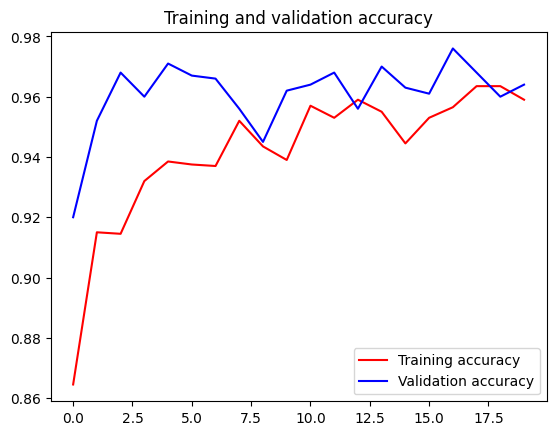

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()